**Install dependencies**

In [1]:
# %%capture
# !pip install -U torch torchvision torchaudio
# !pip install numpy pandas pillow gradio
# !pip install -U cjm_pil_utils cjm_kaggle_utils cjm_pytorch_utils

**Import dependencies**

In [2]:
from pathlib import Path
import random

from PIL import Image
import numpy as np
import timm
from tqdm.auto import tqdm
import gradio as gr

# Import pandas module for data manipulation
import pandas as pd

# Set options for Pandas DataFrame display
pd.set_option('max_colwidth', None)  # Do not truncate the contents of cells in the DataFrame
pd.set_option('display.max_rows', None)  # Display all rows in the DataFrame
pd.set_option('display.max_columns', None)  # Display all columns in the DataFrame

# Import PyTorch dependencies
import torch
from torchvision import transforms, models

# Import utility functions
from cjm_kaggle_utils.core import save_kaggle_creds, dl_kaggle
from cjm_pil_utils.core import resize_img, get_img_files, stack_imgs
from cjm_pytorch_utils.core import pil_to_tensor, get_torch_device

**Set device and data type**

In [3]:
device = get_torch_device()
dtype = torch.float16 if device == 'cuda' else torch.float32
device, dtype

('cuda', torch.float16)

**Enter Kaggle username and API token**

In [4]:
username = ""
key = ""

**Save Kaggle credentials to file**

In [5]:
save_kaggle_creds(username, key, overwrite=False)

Empty username.


**Define directory paths**

In [6]:
# Define path to store datasets
dataset_dir = Path("/mnt/980_1TB_2/Datasets/")
# Create the dataset directory if it does not exist
dataset_dir.mkdir(parents=True, exist_ok=True)
print(f"Dataset Directory: {dataset_dir}")

# Define path to store archive files
archive_dir = dataset_dir/'../Archive'
# Create the archive directory if it does not exist
archive_dir.mkdir(parents=True, exist_ok=True)
print(f"Archive Directory: {archive_dir}")

Dataset Directory: /mnt/980_1TB_2/Datasets
Archive Directory: /mnt/980_1TB_2/Datasets/../Archive


**Define Kaggle dataset**

In [7]:
# Set the name of the dataset
dataset_name = 'pexels-110k-512p-min-jpg'

# Construct the Kaggle dataset name by combining the username and dataset name
kaggle_dataset = f'innominate817/{dataset_name}'

# Create the path to the zip file that contains the dataset
archive_path = Path(f'{archive_dir}/{dataset_name}.zip')
print(f"Archive Path: {archive_path}")

# Create the path to the directory where the dataset will be extracted
dataset_path = Path(f'{dataset_dir}/{dataset_name}')
print(f"Dataset Path: {dataset_path}")

Archive Path: /mnt/980_1TB_2/Datasets/../Archive/pexels-110k-512p-min-jpg.zip
Dataset Path: /mnt/980_1TB_2/Datasets/pexels-110k-512p-min-jpg


**Download Kaggle dataset**

In [8]:
dl_kaggle(kaggle_dataset, archive_path, dataset_path)

Dataset already downloaded


**Get image paths**

In [9]:
src_img_dir = Path(dataset_path/"images")
src_img_dir

PosixPath('/mnt/980_1TB_2/Datasets/pexels-110k-512p-min-jpg/images')

In [11]:
# Get a list of the paths to the images in the images directory
img_paths = get_img_files(src_img_dir)

# Print the number of images in the images directory
print(len(img_paths))

109971


**Display sample image**

Class: images


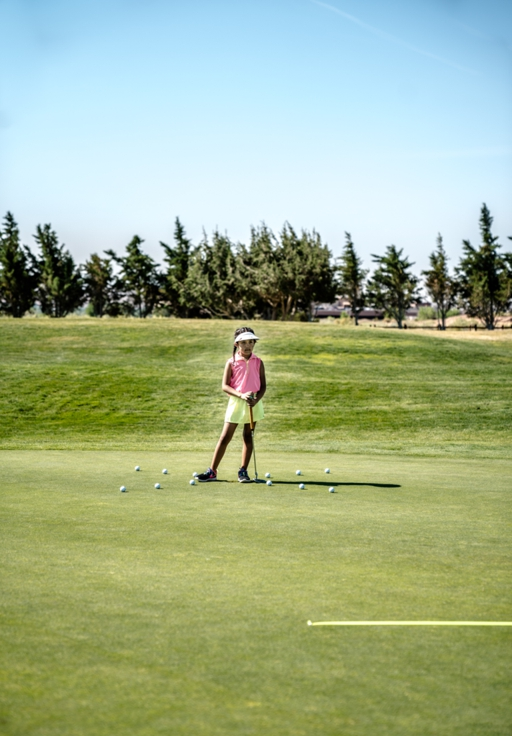

In [12]:
# Choose a random image ID from the list of image IDs
img_path = random.choice(img_paths)

print(f"Class: {img_path.parent.name}")

sample_img = Image.open(img_path)
sample_img

**Set training and validation sets**

In [12]:
# img_paths_subset = random.sample(img_paths, 70000)
img_paths_subset = random.sample(img_paths, len(img_paths))

**List available ResNet18 models**

In [13]:
pd.DataFrame(timm.list_models('resnet18*', pretrained=True))

,0
0,resnet18
1,resnet18d


**Inspect config for ResNet18 model**

In [14]:
# Import the convnext module
from timm.models import resnet

# Choose the resnet model
resnet_model = 'resnet18d'

# Get the default configuration of the chosen model as a Pandas DataFrame
pd.DataFrame.from_dict(resnet.default_cfgs[resnet_model], orient='index')

,0
url,https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/resnet18d_ra2-48a79e06.pth
num_classes,1000
input_size,"(3, 224, 224)"
pool_size,"(7, 7)"
crop_pct,0.875
interpolation,bicubic
mean,"(0.485, 0.456, 0.406)"
std,"(0.229, 0.224, 0.225)"
first_conv,conv1.0
classifier,fc


**Load ResNet18 model**

In [15]:
# Load the resenet model
resnet18 = timm.create_model(resnet_model, pretrained=True, num_classes=len(class_names))

# Set the device and data type
resnet18 = resnet18.to(device=device, dtype=dtype).eval()
resnet18.device = device

**List available ConvNeXt Nano models**

In [16]:
pd.DataFrame(timm.list_models('convnext_nano*', pretrained=True))

,0
0,convnext_nano
1,convnext_nano_ols


**Inspect config for convnext model**

In [17]:
# Import the convnext module
from timm.models import convnext

# Choose the convnext model
convnext_model = 'convnext_nano'

# Get the default configuration of the chosen model as a Pandas DataFrame
pd.DataFrame.from_dict(convnext.default_cfgs[convnext_model], orient='index')

,0
url,https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-rsb-weights/convnext_nano_d1h-7eb4bdea.pth
num_classes,1000
input_size,"(3, 224, 224)"
pool_size,"(7, 7)"
crop_pct,0.95
interpolation,bicubic
mean,"(0.485, 0.456, 0.406)"
std,"(0.229, 0.224, 0.225)"
first_conv,stem.0
classifier,head.fc


**Load convnext_nano model**

In [18]:
# Load the convnext model
convnext_nano = timm.create_model(convnext_model, pretrained=True, num_classes=len(class_names))

# Set the device and data type
convnext_nano = convnext_nano.to(device=device, dtype=dtype).eval()
convnext_nano.device = device

**Select model**

In [19]:
model = resnet18
# model = convnext_nano

**Set normalization stats**

In [20]:
norm_stats = resnet.default_cfgs[resnet_model]['mean'], resnet.default_cfgs[resnet_model]['std']
norm_stats

((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))

**Set checkpoint directory**

In [21]:
# Create a directory to store the checkpoints if it does not already exist
checkpoint_dir = Path("./hagrid_checkpoints/")
checkpoint_dir.mkdir(parents=True, exist_ok=True)

# Print the checkpoint path
checkpoint_dir

PosixPath('hagrid_checkpoints')

**Set checkpoint path**

In [22]:
checkpoint_path = checkpoint_dir/"resnet18d-trivial-aug-item-1.pth"
checkpoint_path

PosixPath('hagrid_checkpoints/resnet18d-trivial-aug-item-1.pth')

**Load model checkpoint**

In [23]:
model.load_state_dict(torch.load(checkpoint_path));

**Test model**

Class: mute
Predicted Class: mute


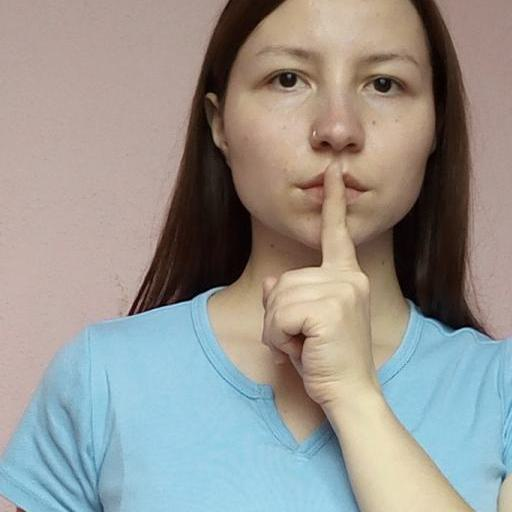

In [24]:
# Choose a random image ID from the list of image IDs
img_path = random.choice(img_paths)

print(f"Class: {img_path.parent.name}")

sample_img = Image.open(img_path)
inp_img = resize_img(sample_img.copy(), 288)

img_tensor = pil_to_tensor(inp_img, *norm_stats).to(device=device, dtype=dtype)

with torch.no_grad():
        pred = model(img_tensor)
        
pred_class = class_names[torch.argmax(torch.sigmoid(pred))]
        
print(f"Predicted Class: {pred_class}")


sample_img

**Perform inference on test set**

In [25]:
wrong_imgs = []

for path in tqdm(img_paths_subset):
    target_cls = path.parent.name

    sample_img = Image.open(path)
    sample_img = resize_img(sample_img, 288)

    img_tensor = pil_to_tensor(sample_img, *norm_stats).to(device=device, dtype=dtype)

    with torch.no_grad():
            pred = model(img_tensor)

    pred_cls = class_names[torch.argmax(torch.sigmoid(pred))]
    
#     if pred_cls != target_cls: wrong_imgs.append(path)
    if pred_cls != target_cls and (pred_cls == "no_gesture" or target_cls == "no_gesture"): wrong_imgs.append(path)

len(wrong_imgs)

  0%|          | 0/154393 [00:00<?, ?it/s]

223

**Inspect the number of wrong predictions per class**

In [26]:
wrong_imgs_df = pd.DataFrame(wrong_imgs)
wrong_imgs_df['class'] = wrong_imgs_df.apply(lambda row: Path(row[0]).parent.stem, axis=1)

class_dist_df = wrong_imgs_df['class'].value_counts().to_frame()#.rename(columns={"class":run_name})
class_dist_df.rename_axis("class", inplace=True)
class_dist_df

,class
class,
no_gesture,54
like,21
fist,16
dislike,15
one,13
stop_inverted,12
peace_inverted,11
two_up_inverted,11
two_up,10


**Set image paths for gradio interface**

In [27]:
gr_img_paths = wrong_imgs
len(gr_img_paths)

223

**Initialize list of images to delete**

In [28]:
marked_imgs = []

**Initialize list index**

In [29]:
index = 0

**Define functions for gradio interface**

In [30]:
def get_pred(img_path):
    inp_img = resize_img(Image.open(img_path), 288)

    img_tensor = pil_to_tensor(inp_img, *norm_stats).to(device=device, dtype=dtype)

    with torch.no_grad():
            pred = model(img_tensor)

    return class_names[torch.argmax(torch.sigmoid(pred))]

# Function to go to the previous image
def prev_image():
    global index
    global marked_imgs
    index = index - 1 if index > 0 else len(gr_img_paths)-1
    img_path = gr_img_paths[index]
    btn_val = "Unmark" if img_path in marked_imgs else "Mark to Delete"
    return gr_img_paths[index], gr_img_paths[index].parent.name, get_pred(img_path), btn_val

# Function to go to the next image
def next_image():
    global index
    global marked_imgs
    index = index + 1 if index < len(gr_img_paths)-1 else 0
    img_path = gr_img_paths[index]
    btn_val = "Unmark" if img_path in marked_imgs else "Mark to Delete"
    return gr_img_paths[index], gr_img_paths[index].parent.name, get_pred(img_path), btn_val
    
def mark_to_delete():
    global index
    global marked_imgs
    img_path = gr_img_paths[index]
    if img_path in marked_imgs: 
        marked_imgs.remove(img_path)
        return "Mark to Delete"
    else:
        marked_imgs.append(img_path)
        return "Unmark"

**Create gradio interface**

In [31]:
with gr.Blocks() as demo:
    with gr.Row():
        prev_button = gr.Button('Previous')
        next_button = gr.Button('Next')
    with gr.Row():
        mark_del_button = gr.Button('Mark to Delete')
    with gr.Row():
        img_class_text = gr.Text(gr_img_paths[index].parent.name, label="Image Class")
        pred_class_text = gr.Text(get_pred(gr_img_paths[index]), label="Predicted Class")

    image_output = gr.Image(gr_img_paths[index])

    prev_button.click(prev_image, outputs=[image_output, img_class_text, pred_class_text, mark_del_button])
    next_button.click(next_image, outputs=[image_output, img_class_text, pred_class_text, mark_del_button])
    mark_del_button.click(mark_to_delete, outputs=[mark_del_button])
        
demo.launch(height=1600)

Running on local URL:  http://127.0.0.1:7860

To create a public link, set `share=True` in `launch()`.


In [36]:
index

0

In [37]:
len(marked_imgs)

44

**Delete marked images**

In [38]:
for path in marked_imgs:
    if path.exists():
        path.unlink()